# Projeto 3
### Equipe: Gabriel Couto, Luiz Felipe e Rogério Ferrari

##### Importando bibliotecas:

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

##### Carregando dados e organizando:

In [8]:
dados = pd.read_table('seguros.csv', encoding="UTF", sep=",")
dados.columns = ['Idade','Sexo', 'IMC','Filhos', 'Fumante', 'Regiao', 'Despesas']

#Remove colunas desnecessárias
dados.drop('Regiao', axis=1, inplace=True) 

#Convertendo Sexo para inteiros // 0 = homem, 1 = mulher
dados.loc[dados[dados.Sexo=="male"].index,"Sexo"] = 0
dados.loc[dados[dados.Sexo=="female"].index,"Sexo"] = 1

#Convertendo Fumante para inteiros // 0 = não fumante, 1 = fumante
dados.loc[dados[dados.Fumante=="no"].index,"Fumante"] = 0
dados.loc[dados[dados.Fumante=="yes"].index,"Fumante"] = 1
dados.Fumante = dados.Fumante.astype('int')

#Convertendo IMC e Despesas
for i in range(len(dados)):
    dados.at[i,'IMC'] = round(dados.at[i,'IMC'], 1)
dados.Despesas = dados.Despesas.astype('int')

##### Separarando parte de teste e lendo o dataset:

In [9]:
if len(dados) > 1000:
    teste = dados.iloc[838:1338,:]
    dados.drop(dados.index[838:], inplace=True)
print("Comprimento dados:",len(dados),"| Comprimento teste:",len(teste))
dados.head()

Comprimento dados: 838 | Comprimento teste: 500


,Idade,Sexo,IMC,Filhos,Fumante,Despesas
0,19,1,27.9,0,1,16884
1,18,0,33.8,1,0,1725
2,28,0,33.0,3,0,4449
3,33,0,22.7,0,0,21984
4,32,0,28.9,0,0,3866


## Análise exploratória

##### Correlação entre as colunas:

In [10]:
dados.corr()

,Idade,Sexo,IMC,Filhos,Fumante,Despesas
Idade,1.000000,0.054722,0.116414,0.058041,-0.015038,0.317232
Sexo,0.054722,1.000000,-0.001433,-0.020959,-0.093896,-0.044870
IMC,0.116414,-0.001433,1.000000,0.036446,-0.010248,0.192461
Filhos,0.058041,-0.020959,0.036446,1.000000,0.002153,0.062619
Fumante,-0.015038,-0.093896,-0.010248,0.002153,1.000000,0.786088
Despesas,0.317232,-0.044870,0.192461,0.062619,0.786088,1.000000


 A correlação entre as colunas Despesas e Fumante é bem maior que a correlação entre Despesas e qualquer outra coluna.

##### Parcela de fumantes:

In [11]:
fuma_ou_nao = dados.Fumante.value_counts(True)
print("Fumantes:", 100*round(fuma_ou_nao[0],3),"%"," |","Não Fumantes:", 100*round(fuma_ou_nao[1],3),"%")

Fumantes: 80.4 %  | Não Fumantes: 19.6 %


##### Histograma das despesas:

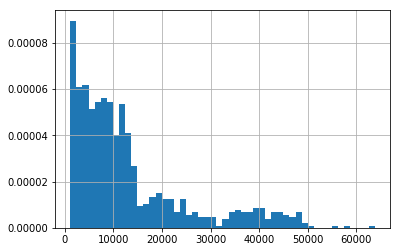

In [12]:
dados["Despesas"].hist(density=True, bins=50);

Pela distribuição do histograma podemos dividir a amostra por renda em 4 categorias pelos pontos: 15000, 30000 e 50000.

##### Dividindo Despesas em 4 categorias:

In [13]:
for i in range(len(dados['Despesas'])):
    if dados.loc[i,'Despesas'] <= 15000:
        dados.at[i,'Despesas'] = 0
    if dados.loc[i,'Despesas'] > 15000 and dados.loc[i,'Despesas'] <= 30000:
        dados.at[i,'Despesas'] = 1
    if dados.loc[i,'Despesas'] > 30000 and dados.loc[i,'Despesas'] <= 50000:
        dados.at[i,'Despesas'] = 2
    if dados.loc[i,'Despesas'] > 50000:
        dados.at[i,'Despesas'] = 3

Como Despesas e Fumante são agora qualitativas usaremos regressão logística.



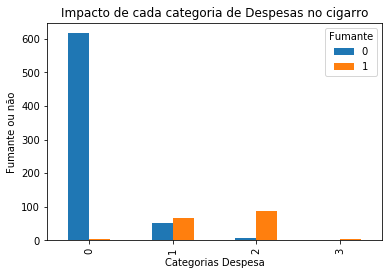

In [14]:
%matplotlib inline
pd.crosstab(dados.Despesas,dados.Fumante).plot(kind='bar')
plt.title('Impacto de cada categoria de Despesas no cigarro')
plt.xlabel('Categorias Despesa')
plt.ylabel('Fumante ou não');

A partir do gráfico acima, portanto, podemos perceber que as duas categorias de despesa que mais impactam em uma pessoa ser fumante ou não, são as categorias 1 e 2, ou seja, pessoas que gastam desde 15.000 dólares até no máximo 50.000 dólares. E portanto, estes são dados que impactam no resultado final.

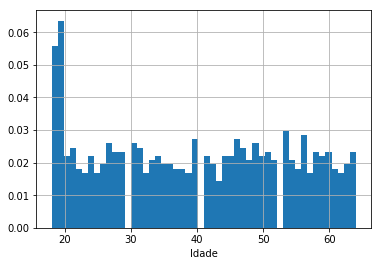

In [22]:
%matplotlib inline
dados.Idade.hist(density=True, bins=50)
plt.xlabel('Idade');

In [29]:
dados.Idade.value_counts()

19    49
18    43
53    23
56    22
40    21
46    21
49    20
27    20
30    20
21    19
31    19
47    19
28    18
29    18
64    18
51    18
60    18
58    18
50    17
34    17
20    17
24    17
59    17
41    17
45    17
44    17
54    16
48    16
52    16
33    16
63    15
36    15
35    15
26    15
42    15
55    14
37    14
22    14
61    14
38    14
57    13
39    13
32    13
25    13
23    13
62    13
43    11
Name: Idade, dtype: int64

Conseguimos perceber a partir do histograma acima que a idade que as pessoas mais fumam é aproximadamente entre 18 e 20 anos, o que pode ser confirmado pelos dados abaixo. 

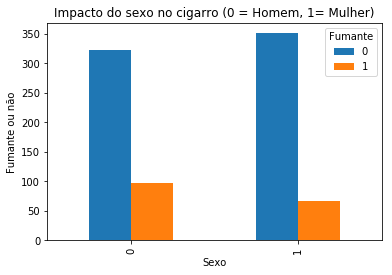

In [30]:
%matplotlib inline
pd.crosstab(dados.Sexo,dados.Fumante).plot(kind='bar')
plt.title('Impacto do sexo no cigarro (0 = Homem, 1= Mulher)')
plt.xlabel('Sexo')
plt.ylabel('Fumante ou não');

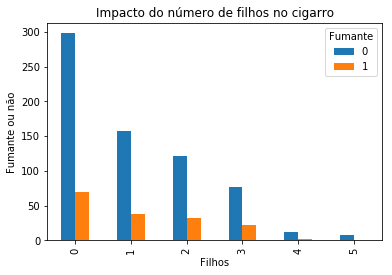

In [31]:
%matplotlib inline
pd.crosstab(dados.Filhos,dados.Fumante).plot(kind='bar')
plt.title('Impacto do número de filhos no cigarro')
plt.xlabel('Filhos')
plt.ylabel('Fumante ou não');

A medida em que o número de filhos aumenta, a taxa de fumantes diminui, como uma escada, porque o número de pessoas com uma quantidade maior de filhos é cada vez menor.

# Iniciando a Regressão

A princípio foi pensado em realizar o projeto utilizando Naive Bayes e tentando prever se a pessoa era fumante ou não. Porém, pensando mais afundo, resolvemos ver qual o impacto de uma variável na "causa" que queríamos estudar, que no caso é a pessoa ser fumante ou não. 

Sendo assim, a maneira de calcular como um valor interfere no outro é através da Regressão, porém, não apenas de uma variável, mas sim de várias, portanto, uma regressão múltipla. E pelo fato de a resposta possível ser "sim" ou "não", no caso "1" e "0", é utilizada a Regressão Logística.

In [51]:
#Pegar amostra de 200 elementos:
train = dados.sample(n=200)
fuma_ou_nao = train.Fumante.value_counts(True)
print("Fumantes:", 100*round(fuma_ou_nao[0],4),"%"," |","Não Fumantes:", 100*round(fuma_ou_nao[1],4),"%")

Fumantes: 82.0 %  | Não Fumantes: 18.0 %


É visto nos dados acima que a taxa de pessoas que não são fumantes é muito maior que a taxa de pessoas que fumam. Sendo assim, para que não haja nenhuma influência para um lado nos resultados, iremos deixar os dados aproximadamente iguais entre quem fuma e quem não fuma.

In [52]:
from imblearn.over_sampling import SMOTE

x = dados.iloc[:,[0,1,2,3,5]]
y = dados.Fumante

rand = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
coluna = X_train.columns

rand_data_X,rand_data_y=rand.fit_sample(X_train, y_train)
rand_data_X = pd.DataFrame(data=rand_data_X,columns=coluna )
rand_data_y= pd.DataFrame(data=rand_data_y,columns=['y'])

print("Não fumantes: ",(len(rand_data_y[rand_data_y['y']==0])/len(rand_data_X))*100, '%')


Não fumantes:  50.0 %


Portanto, agora os dados tendem a não tender para um lado, deixando os resultados mais justos.

In [53]:
sgd_clf = LogisticRegression()  # Existe aleatoriedade dentro do SGDClassifier.
sgd_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
teste = sgd_clf.predict(X_test)
y_pred = sgd_clf.predict(X_test)
print('Acurácia: {}'.format(accuracy_score(y_test, y_pred)))

Acurácia: 0.9365079365079365


In [55]:
varind = np.asarray(dados[["Idade","Sexo","IMC","Despesas"]])
varind = sm.add_constant(varind)
vardep = dados["Fumante"]
mod = sm.OLS(vardep.astype(float),varind.astype(float))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Fumante   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     514.4
Date:                Thu, 22 Nov 2018   Prob (F-statistic):          2.70e-223
Time:                        19:53:30   Log-Likelihood:                 106.92
No. Observations:                 838   AIC:                            -203.8
Df Residuals:                     833   BIC:                            -180.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3162      0.043      7.427      0.000       0.233       0.400
x1            -0.0012      0.001     -2.370      0.018      -0.002      -0.000
x2            -0.0159      0.015     -1.073      0.283      -0.045       0.013
x3            -0.0080      0.001     -6.401      0.000      -0.010      -0.006
x4             0.4809      0.011     45.071      0.000       0.460       0.502
==============================================================================
Omnibus:                      108.242   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              868.733
Skew:                          -0.257   Prob(JB):                    2.27e-189
Kurtosis:                       7.961   Cond. No.                         299.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

O modelo, como nos mostra o R-quadrado, explica 71,2% da variância em nosso y (Fumante ou não) e 